In [12]:
import numpy as np
import mido
import pretty_midi
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600

In [3]:
def notes_to_instrument(notes, who_is_main, player_id, type_inst=0):
    instrument = pretty_midi.Instrument(type_inst)
    to_write = []
    for i in range(len(notes)):
        note_to_write = None
        if who_is_main[i] == player_id:
            note_to_write = pretty_midi.Note(100,notes[i],i,i+1)
        else:
            note_to_write = pretty_midi.Note(25,notes[i],i,i+1)
        to_write.append(note_to_write)
    instrument.notes = to_write
    return instrument

In [4]:
def calculate_distance(playing, potential, melody):    
    diff = np.sum(np.abs(playing-potential))
    
    score = 10-(diff-1)
    
    good_differences = [0, 3, 4, 5, 7, 8, 9]
    
    internal_diff = np.abs(melody[1:] - melody[:-1])
    
    #for n in internal_diff:
        #score += 0.3 if n in internal_diff%12 else 0
    
    return score

In [5]:
def make_order(melody):
    order = np.zeros(len(melody))
    for i in range(1,len(melody)):
        if melody[i-1] < melody[i]:
            order[i] = 1
        elif melody[i-1] > melody[i]:
            order[i] = -1
    return order

In [6]:
class Player():
    def __init__(self, instrument):
        self.instrument = instrument
        self.isMainVoice = False
        self.melody = np.random.randint(54, 76, 8)
        self.ord = make_order(self.melody)
        self.hist = np.ones(76-54)
        self.score = 0
        self.playing = None
        self.energy = 1
        
        self.energyplot = []
        self.scoreplot = []
    
    def set_other_players(self, others):
        self.others = others
        
    def become_main(self):
        if not self.isMainVoice:
            self.energy += 0.0
        self.isMainVoice = True
        self.playing = self
        self.score = calculate_distance(self.ord, self.ord, self.melody)
        
        for player in self.others:
            player.set_playing(self)
    
    def set_playing(self, playing):
        self.playing = playing
        
        """if self.isMainVoice:
            for i in range(2):
                index1 = np.random.randint(len(self.melody))
                index2 = np.random.randint(len(self.melody))
                
                stored = self.melody[index2]
                
                self.melody[index2] = self.melody[index1]
                self.melody[index1] = stored
            self.ord = make_order(self.melody)
            self.score = calculate_distance(playing.ord, self.ord, self.melody)"""
        
        self.isMainVoice = False
    
    def adjust_melody(self):
        self.score = calculate_distance(self.playing.ord, self.ord, self.melody)
        new_melody = np.copy(self.melody)
        for i in range(len(new_melody)):
            if np.random.random() < 0.1:
                new_melody[i] = np.random.choice([i for i in range(54,76)], p=self.hist/np.sum(self.hist))
                #new_melody[i] = max(min(75, new_melody[i]), 54)
        new_ord = make_order(new_melody)
        new_score = calculate_distance(self.playing.ord, new_ord, self.melody)
        
        if new_score > self.score:
            self.melody = new_melody
            self.ord = new_ord 
            self.score = new_score
            
    def update(self):
        self.energyplot.append(self.energy)
        self.scoreplot.append(self.score*self.energy)
        self.hist[self.melody[j%len(self.melody)]-54] += 1
        if not self.isMainVoice:
            self.adjust_melody()
            self.energy += 0.02
        else:
            self.energy -= 0.03
            highest_score = self.score*self.energy
            best_player = self
            
            for player in self.others:
                if player.score*player.energy > highest_score:
                    #print(player.score, highest_score)
                    highest_score = player.score*player.energy
                    best_player = player
                    print(self.ord, self.energy, best_player.ord, best_player.energy)
            
            
            best_player.become_main()

The idea here is that by measuring their willingness to play with "energy", you can have the person playing the main note get "tired" of playing, and therefore passing the lead voice over to someone else. When you're passed the lead voice, you're also given a burst of energy, which means you'll most likely keep the solo for a little while

In [19]:
p1 = Player(1)
p2 = Player(57)
p3 = Player(40)
p4 = Player(64)

p1.set_other_players([p2, p3, p4])
p2.set_other_players([p1, p3, p4])
p3.set_other_players([p2, p1, p4])
p4.set_other_players([p1, p2, p3])

p1_out = []
p2_out = []
p3_out = []
p4_out = []

p1.become_main()

players = [p1, p2, p3, p4]
outputs = [p1_out, p2_out, p3_out, p4_out]
who_is_main = []

time_since_last_change = 0
current_main = 0

for j in range(250):
    for i in range(len(players)):
        if players[i].isMainVoice:
            who_is_main.append(i)
            
            if current_main == i:
                time_since_last_change += 1
            else:
                time_since_last_change = 0
                current_main = i
        
        outputs[i].append(players[i].melody[j%len(players[i].melody)])
    
    for player in players:
        player.update()
        
print(who_is_main)

print(p1.hist)
print(p2.hist)
print(p3.hist)
print(p4.hist)

midi = pretty_midi.PrettyMIDI()
p1_instrument = notes_to_instrument(p1_out, who_is_main, 0, p1.instrument)
p2_instrument = notes_to_instrument(p2_out, who_is_main, 1, p2.instrument)
p3_instrument = notes_to_instrument(p3_out, who_is_main, 2, p3.instrument)
p4_instrument = notes_to_instrument(p4_out, who_is_main, 3, p4.instrument)
midi.instruments = [p1_instrument, p2_instrument, p3_instrument, p4_instrument]
midi.write("AuctioningWithOrderScale.mid")

[ 0.  0.  1.  1. -1. -1. -1.  1.] 0.7899999999999998 [ 0.  1.  1.  1. -1.  1. -1.  1.] 1.12
[ 0.  1.  1.  1. -1.  1. -1.  1.] 0.8199999999999998 [ 0.  1. -1.  1.  1.  1. -1.  1.] 1.3200000000000003
[ 0.  1. -1.  1.  1.  1. -1.  1.] 0.99 [ 0.  1. -1. -1.  1.  1. -1.  1.] 1.5400000000000005
[ 0.  1. -1. -1.  1.  1. -1.  1.] 1.1500000000000001 [ 0.  1.  1. -1.  1.  1. -1.  1.] 1.4500000000000004
[ 0.  1.  1. -1.  1.  1. -1.  1.] 1.1800000000000002 [ 0.  1. -1. -1.  1.  1. -1.  1.] 1.4600000000000004
[ 0.  1. -1. -1.  1.  1. -1.  1.] 1.3400000000000003 [ 0.  1. -1. -1.  1.  1. -1.  1.] 1.3900000000000003
[ 0.  1. -1. -1.  1.  1. -1.  1.] 1.3300000000000003 [ 0.  1. -1. -1.  1.  1. -1.  1.] 1.3600000000000003
[ 0.  1. -1. -1.  1.  1. -1.  1.] 1.3000000000000003 [ 0.  1. -1. -1.  1.  1. -1.  1.] 1.3500000000000003
[ 0.  1. -1. -1.  1.  1. -1.  1.] 1.2900000000000003 [ 0.  1. -1. -1.  1.  1. -1.  1.] 1.3200000000000003
[ 0.  1. -1. -1.  1.  1. -1.  1.] 1.2900000000000003 [ 0.  1. -1.  1.  1. 

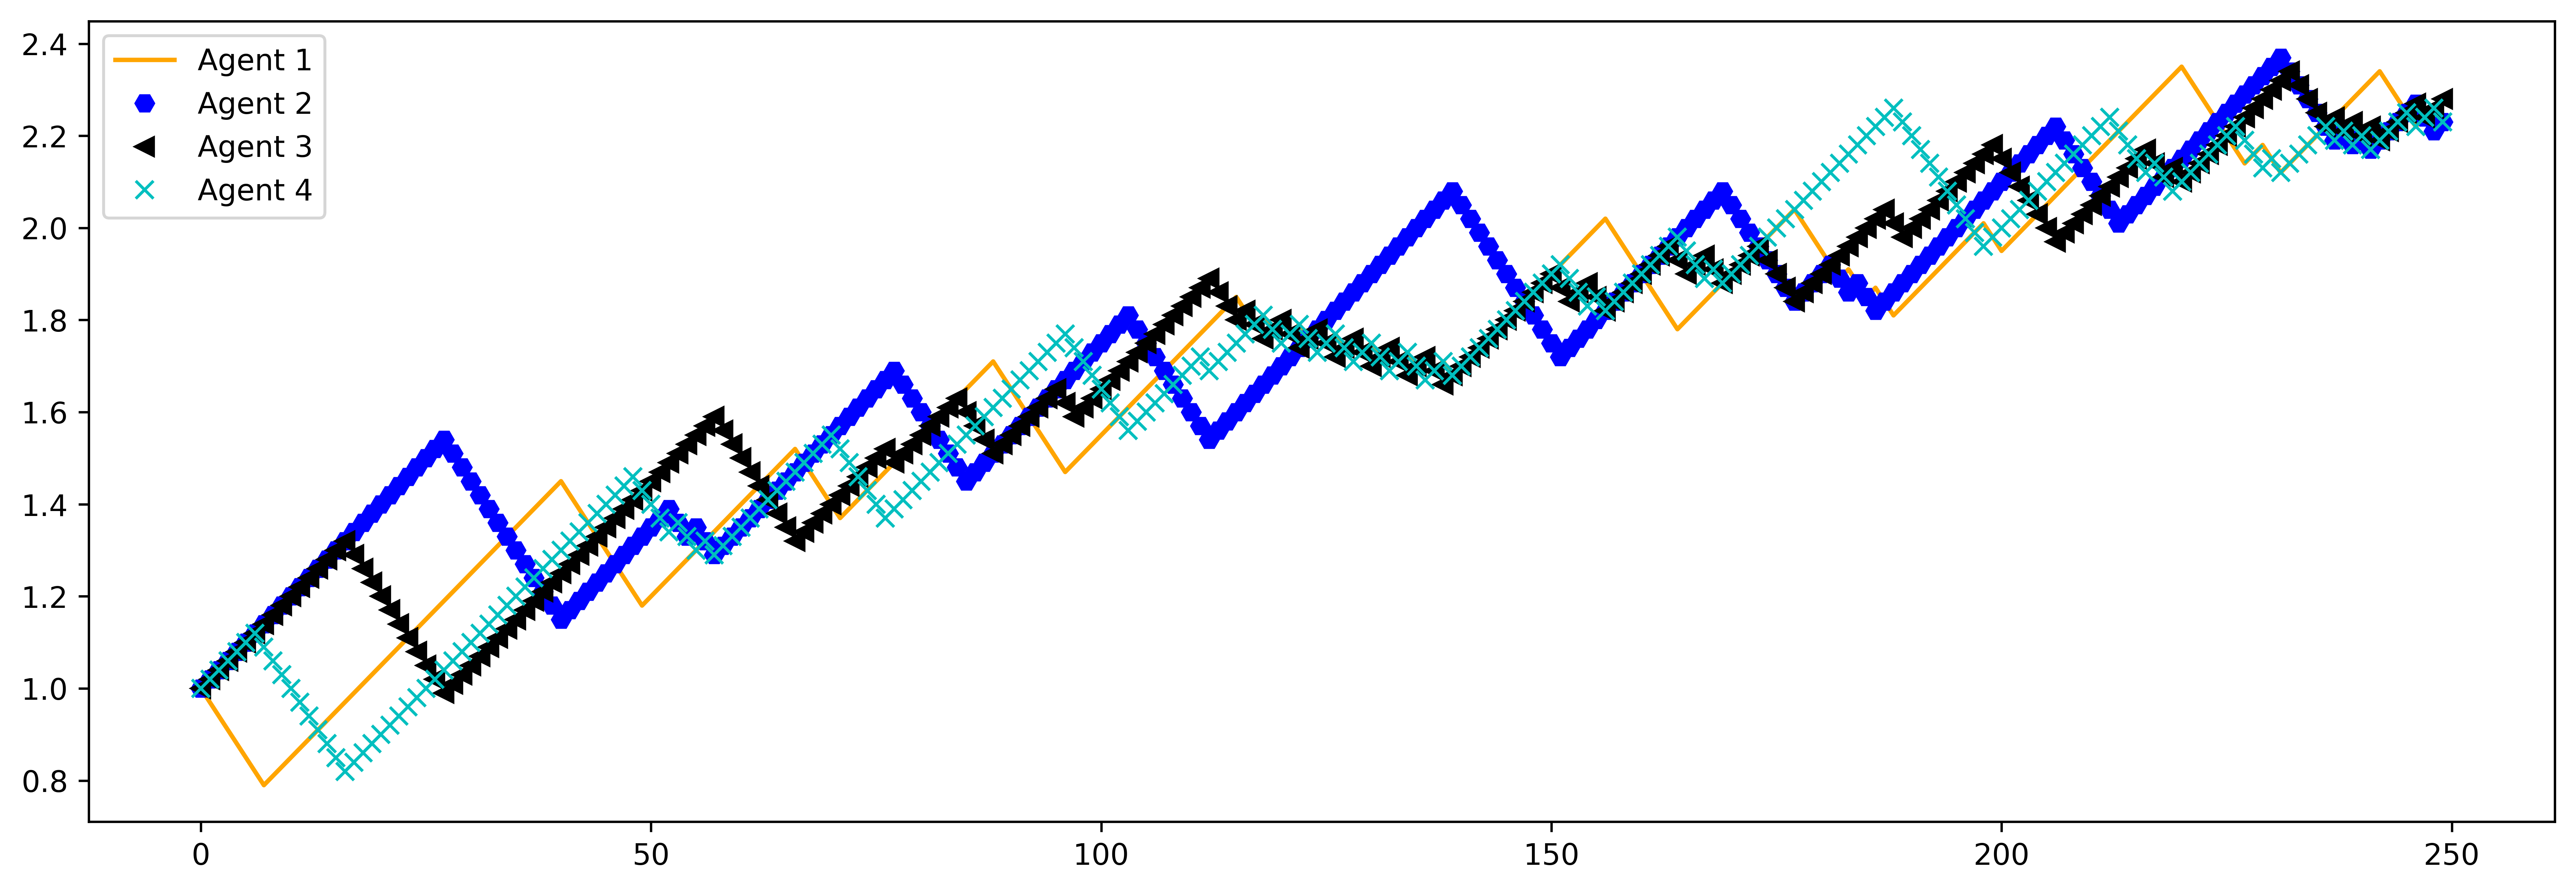

In [31]:
plt.figure(figsize=(15, 5))
plt.plot(p1.energyplot, color='orange', label="Agent 1")
plt.plot(p2.energyplot, 'bH', label="Agent 2")
plt.plot(p3.energyplot, 'k<', label="Agent 3")
plt.plot(p4.energyplot, 'cx', label="Agent 4")
plt.legend()
plt.show()

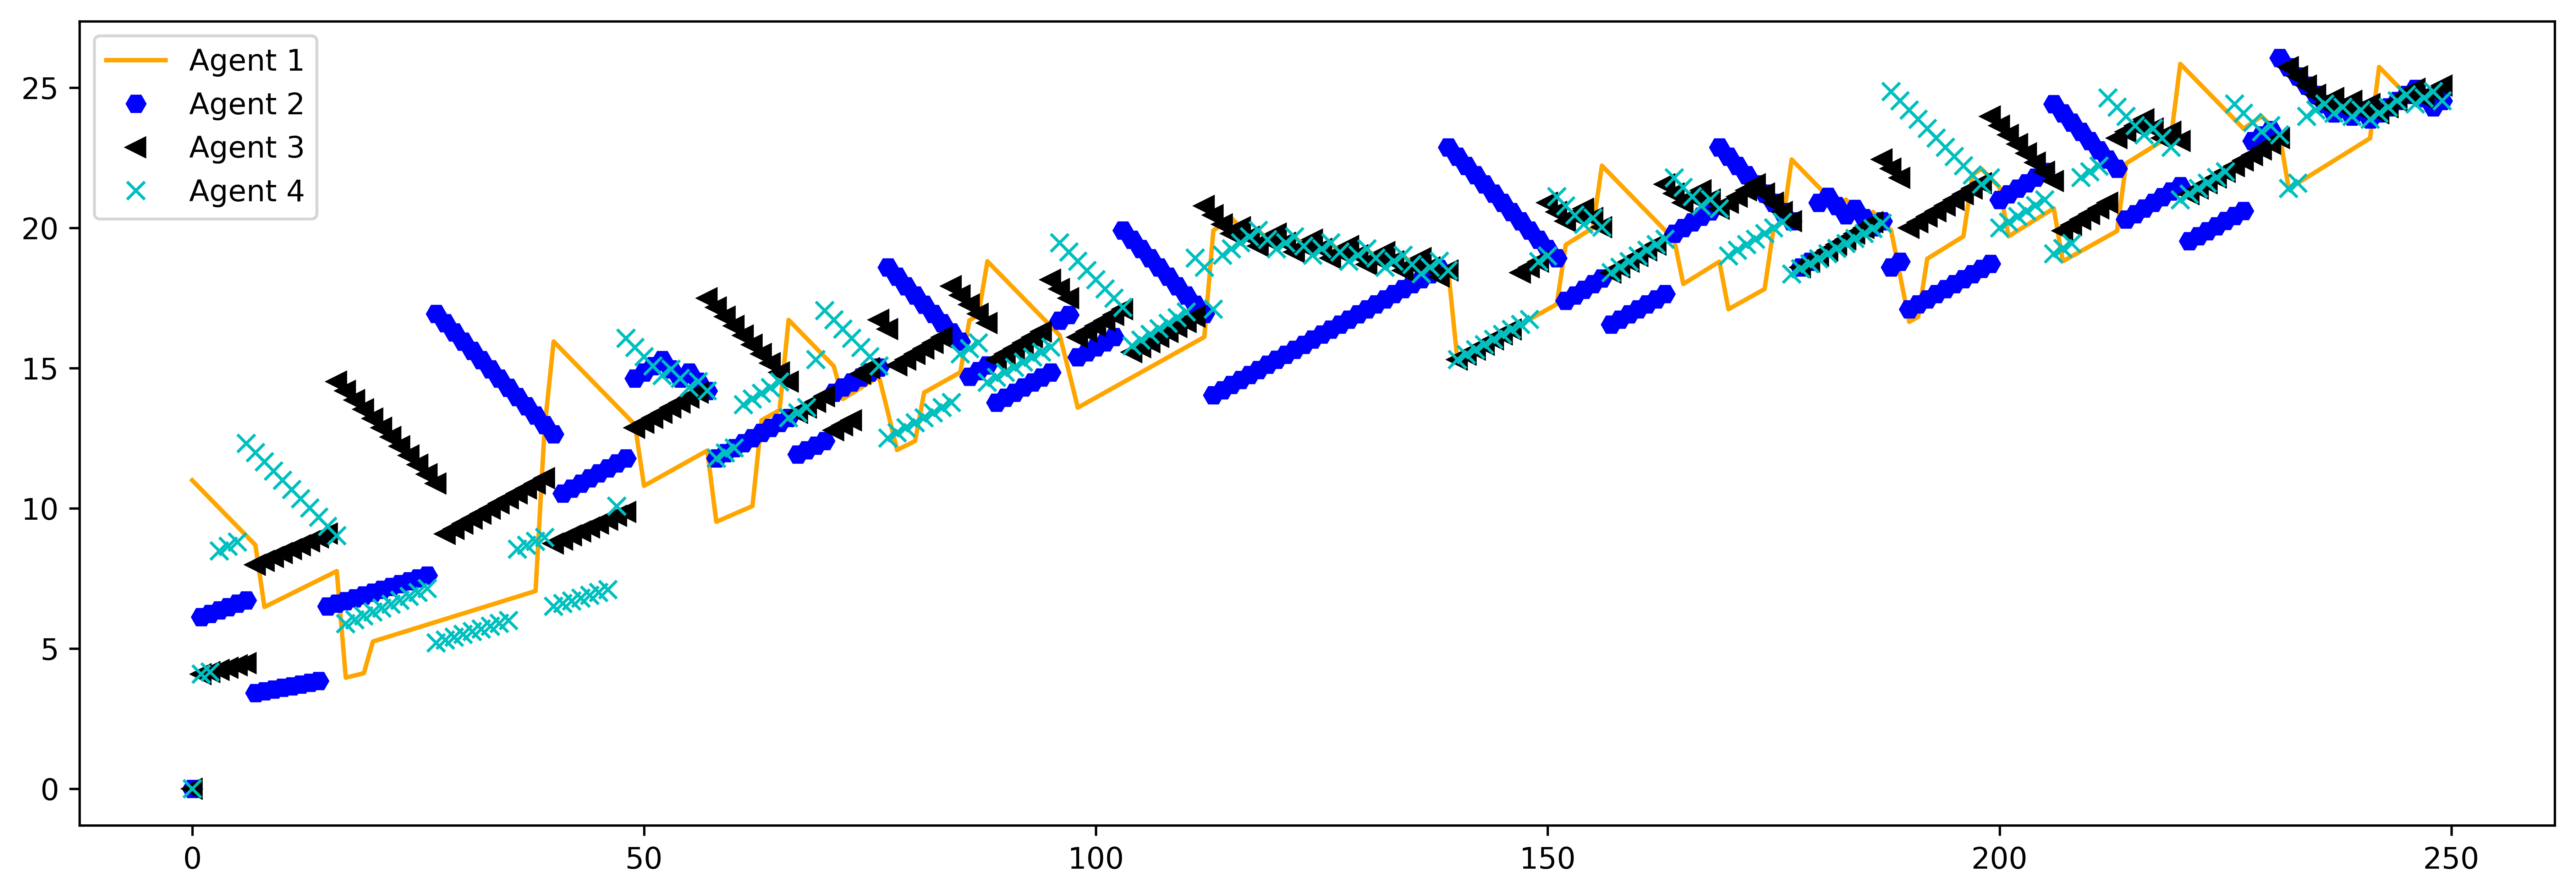

In [33]:
plt.figure(figsize=(15, 5))
plt.plot(p1.scoreplot, color='orange', label="Agent 1")
plt.plot(p2.scoreplot, 'bH', label="Agent 2")
plt.plot(p3.scoreplot, 'k<', label="Agent 3")
plt.plot(p4.scoreplot, 'cx', label="Agent 4")
plt.legend()
plt.show()